In [34]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pytz
import datetime

pd.set_option('display.max_columns', None)

## Pre-Process Data


```
python -u /deep/u/tomjin/philips-ecg-parser/parse_xml_folder.py -i /deep/group/ed-monitor/admission-ecgs/v1/ecgs -o /deep/group/ed-monitor/admission-ecgs/v1/processed.csv -n /deep/group/ed-monitor/admission-ecgs/v1/processed.dat.npy

```

## Load Files

In [35]:
# This is the Myocardial Injury project patients of interest
consolidated = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.csv")
consolidated_csns = set(consolidated["CSN"].tolist())
consolidated.shape

(10874, 79)

In [28]:
# Waveforms are very large - this may take a few minutes to load
waveforms = np.load("/deep/group/ed-monitor/admission-ecgs/v1/processed.dat.npy")

In [29]:
waveforms.shape

(42305, 12, 5500)

In [ ]:
# This accompanies the waveforms, to describe each one
processed = pd.read_csv("/deep/group/ed-monitor/admission-ecgs/v1/processed.csv")
print(processed.shape)
processed.head(3)

In [ ]:
# Filter for NaN CSNs
print(f"Before {processed.shape}")
print(f"No CSN for: {processed[processed['csn'].isna()]['input_file_name']}")
processed = processed[~processed["csn"].isna()]
print(f"After NaN filtering: {processed.shape}")

In [ ]:
# Get CSNs
valid_csns = {}
for csn in processed["csn"].tolist():
    try:
        a = int(csn)
        if a not in valid_csns:
            valid_csns[a] = 0
        valid_csns[a] += 1
    except:
        print(f"CSN {csn} in {processed[processed['csn'] == csn]['input_file_name'].tolist()} is not valid")

In [ ]:
# These are the ECG summary files that came with the raw data
ecgs = pd.read_csv("/deep/group/ed-monitor/admission-ecgs/v1/ecgs.csv")
ecgs = ecgs.drop("PAT_NAME", axis=1)
print(ecgs.shape)
ecgs.head(3)

## Examine Processed ECGs Among Myocardial Injury Patients

In [38]:
df_summary = processed

In [42]:
# Keep first ECG of each CSN patient

csns_processed = set()
indices_to_keep = set()
df_summary = df_summary.sort_values(by=['date', 'time'])
for i, row in df_summary.iterrows():
    try:
        csn = int(row["csn"])

        # TODO: Each CSN could have multiple ECGs taken. Here, we take the first occurrence but we could 
        # expand this to use the average of all ECGs.
        if csn not in csns_processed:
            csns_processed.add(csn)
            indices_to_keep.add(i)
    except:
        pass

print(f"Found {len(csns_processed)} and {len(indices_to_keep)}")

Found 21997 and 21997


In [43]:
df_summary = df_summary[df_summary.index.isin(indices_to_keep)]
df_summary.shape

(21997, 31)

In [44]:
df_summary["csn"] = df_summary["csn"].astype(int)

In [45]:
consolidated.shape

(10874, 79)

In [46]:
# Filter summary file by the consolidated file

patient_ids = set(consolidated["patient_id"].tolist())
df_summary = df_summary[df_summary["csn"].isin(patient_ids)]
df_summary.shape

(10250, 31)

In [ ]:
# Make sure each 12-lead ECG was actually taken during the ED visit

buffer_hours = 3
good = 0
bad = 0

for i, row in tqdm(df_summary.iterrows()):
    csn = row["csn"]
    date = row["date"]
    time = row["time"]
    try:
        capture_time = f"{date}T{time}Z"
        capture_time = datetime.datetime.strptime(capture_time, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        capture_time = pytz.timezone('America/Vancouver').localize(capture_time)

        admit_time = consolidated[consolidated["CSN"] == csn].iloc[0]["Arrival_time"]
        departure_time = consolidated[consolidated["CSN"] == csn].iloc[0]["Departure_time"]
        departure_time = consolidated[consolidated["CSN"] == csn].iloc[0]["First_trop_collection_time"]

        admit_time = datetime.datetime.strptime(admit_time, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        admit_time = pytz.timezone('America/Vancouver').localize(admit_time)
        departure_time = datetime.datetime.strptime(departure_time, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        departure_time = pytz.timezone('America/Vancouver').localize(departure_time)

        if not (capture_time < departure_time and capture_time > (admit_time - datetime.timedelta(hours=buffer_hours))):
            print(f"INVALID ECG: {csn} | CAPTURE={capture_time}; ADMIT={admit_time}; DEPART={departure_time}")
            bad += 1
        else:
            good += 1
    except:
        print(f">> Error parsing dates for {csn}")
    
print(f"Good = {good}; bad = {bad}; total = {good+bad}")

In [50]:
# How many would we have if we were to use the first trop result time as end boundary

buffer_hours = 3
good = 0
bad = 0
good_csns = set()

for i, row in tqdm(df_summary.iterrows()):
    csn = row["csn"]
    date = row["date"]
    time = row["time"]
    try:
        capture_time = f"{date}T{time}Z"
        capture_time = datetime.datetime.strptime(capture_time, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        capture_time = pytz.timezone('America/Vancouver').localize(capture_time)

        admit_time = consolidated[consolidated["CSN"] == csn].iloc[0]["Arrival_time"]
        departure_time = consolidated[consolidated["CSN"] == csn].iloc[0]["First_trop_result_time"]

        admit_time = datetime.datetime.strptime(admit_time, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        admit_time = pytz.timezone('America/Vancouver').localize(admit_time)
        departure_time = datetime.datetime.strptime(departure_time, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        departure_time = pytz.timezone('America/Vancouver').localize(departure_time)

        if not (capture_time < departure_time and capture_time > (admit_time - datetime.timedelta(hours=buffer_hours))):
            bad += 1
        else:
            good += 1
            good_csns.add(csn)
    except Exception as e:
        print(f">> Error parsing dates for {csn} {e}")
        break
    
print(f"Good = {good}; bad = {bad}; total = {good+bad}")

10250it [00:29, 353.07it/s]

Good = 9809; bad = 441; total = 10250


In [57]:
# Save the consolidated CSNs

consolidated_train = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.train.txt", sep="\t")
print(f"Read {consolidated_train.shape}; pos = {sum(consolidated_train['outcome'].tolist())}")
consolidated_train = consolidated_train[consolidated_train["CSN"].isin(good_csns)]
print(f"Saved {consolidated_train.shape}; pos = {sum(consolidated_train['outcome'].tolist())}")
consolidated_train.to_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt", index=False, sep="\t")

consolidated_train = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.val.txt", sep="\t")
print(f"Read {consolidated_train.shape}; pos = {sum(consolidated_train['outcome'].tolist())}")
consolidated_train = consolidated_train[consolidated_train["CSN"].isin(good_csns)]
print(f"Saved {consolidated_train.shape}; pos = {sum(consolidated_train['outcome'].tolist())}")
consolidated_train.to_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt", index=False, sep="\t")

consolidated_train = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.test.txt", sep="\t")
print(f"Read {consolidated_train.shape}; pos = {sum(consolidated_train['outcome'].tolist())}")
consolidated_train = consolidated_train[consolidated_train["CSN"].isin(good_csns)]
print(f"Saved {consolidated_train.shape}; pos = {sum(consolidated_train['outcome'].tolist())}")
consolidated_train.to_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt", index=False, sep="\t")


Read (8162, 79); pos = 757
Saved (7246, 79); pos = 670
Read (1356, 79); pos = 150
Saved (1283, 79); pos = 142
Read (1356, 79); pos = 150
Saved (1278, 79); pos = 139


## Check if any embeddings are the same

In [66]:
df_embeddings_summary = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64/embeddings_summary.csv")
df_embeddings_summary.shape

(10250, 1)

In [49]:
embeddings = np.load("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64/embeddings.dat.npy")
embeddings.shape

(10250, 64)

In [56]:
unq, count = np.unique(embeddings, axis=0, return_counts=True)
unq.shape

(10249, 64)

In [58]:
unq[count > 1]

array([[-0.8400398 ,  0.07980677,  0.2826263 , -3.2190666 , -1.9250252 ,
        -1.5715197 ,  0.11731355, -0.76236606, -1.316995  , -1.7388293 ,
         1.1471084 ,  2.208802  ,  2.6703978 , -1.6674052 , -1.7653017 ,
        -0.47862214, -2.4198327 , -0.1546184 , -0.17573671, -2.1286082 ,
        -0.44014063,  2.566614  ,  0.6606206 , -1.5038149 ,  1.0298996 ,
         2.4727924 , -1.6815008 , -2.0885441 , -1.2593323 ,  0.26273936,
         1.6087525 ,  0.48154116,  0.29693344,  2.2257974 , -2.5806215 ,
        -2.0567951 , -1.7792679 , -0.6545973 ,  0.72707886, -0.00943519,
        -1.5540231 , -1.9538554 ,  0.23644707, -1.0016159 , -2.1528292 ,
         1.748175  , -0.9574019 ,  1.8423183 , -2.1150434 , -2.136239  ,
         0.46938103, -0.41051775,  1.556353  , -0.24424422,  0.42825976,
        -1.4723771 ,  1.5866475 , -2.7499566 ,  1.1809089 ,  2.5869772 ,
        -1.7470742 , -1.5943938 , -0.7896998 , -2.9428353 ]],
      dtype=float32)

In [63]:
# Find which indices are duplicates
for i in range(embeddings.shape[0]):
    if np.array_equal(embeddings[i], unq[count > 1][0]):
        print(i)
    

1869
2214


## How many waveforms are truly bad waveforms?

In [ ]:
# Verify that these are only Myocardial injury waveforms from above filtering
print(df_summary.shape)
df_summary.head(1)

In [84]:
import biosppy

waveforms_indices_to_hr = {}
bad_waveforms_indices = []
for ecg_ind in tqdm(df_summary.index):
    ecg = waveforms[ecg_ind][0] # lead I
    try:
        ts, filtered, rpeaks, templates_ts, templates, hr_ts, hr = biosppy.signals.ecg.ecg(ecg, sampling_rate=500, show=False)

        if len(hr) == 0:
            bad_waveforms_indices.append(ecg_ind)
            waveforms_indices_to_hr[ecg_ind] = float("nan")
            print(f"Found bad waveform at = {ecg_ind}")
        else:
            waveforms_indices_to_hr[ecg_ind] = np.mean(hr)
    except:
        bad_waveforms_indices.append(ecg_ind)

  1%|          | 55/10250 [00:01<03:56, 43.09it/s]

Found bad waveform at = 15717


  2%|▏         | 230/10250 [00:05<03:54, 42.77it/s]

Found bad waveform at = 14048


  7%|▋         | 705/10250 [00:16<03:56, 40.33it/s]

Found bad waveform at = 38814


 15%|█▍        | 1516/10250 [00:35<03:24, 42.72it/s]

Found bad waveform at = 28987


 18%|█▊        | 1881/10250 [00:44<03:18, 42.22it/s]

Found bad waveform at = 16614


 27%|██▋       | 2746/10250 [01:04<02:58, 41.94it/s]

Found bad waveform at = 29531


 28%|██▊       | 2921/10250 [01:08<02:52, 42.53it/s]

Found bad waveform at = 23830


 38%|███▊      | 3886/10250 [01:31<02:34, 41.10it/s]

Found bad waveform at = 38816


 49%|████▉     | 4998/10250 [01:57<02:03, 42.61it/s]

Found bad waveform at = 23288


 51%|█████     | 5228/10250 [02:03<02:00, 41.68it/s]

Found bad waveform at = 24185


 59%|█████▊    | 6008/10250 [02:21<01:37, 43.42it/s]

Found bad waveform at = 11131


 62%|██████▏   | 6328/10250 [02:29<01:34, 41.47it/s]

Found bad waveform at = 19656


 69%|██████▉   | 7093/10250 [02:47<01:13, 42.90it/s]

Found bad waveform at = 34404


 79%|███████▊  | 8063/10250 [03:09<00:51, 42.21it/s]

Found bad waveform at = 27032


 81%|████████  | 8328/10250 [03:15<00:44, 43.38it/s]

Found bad waveform at = 32915


 82%|████████▏ | 8418/10250 [03:18<00:42, 43.48it/s]

Found bad waveform at = 1134


 83%|████████▎ | 8463/10250 [03:19<00:41, 43.24it/s]

Found bad waveform at = 41360


 85%|████████▌ | 8743/10250 [03:25<00:36, 41.33it/s]

Found bad waveform at = 27900


 87%|████████▋ | 8898/10250 [03:29<00:31, 42.52it/s]

Found bad waveform at = 19912


 95%|█████████▍| 9728/10250 [03:48<00:11, 43.94it/s]

Found bad waveform at = 19138


100%|██████████| 10250/10250 [04:01<00:00, 42.50it/s]


In [85]:
print(f"Number of bad waveforms = {len(bad_waveforms_indices)}")

Number of bad waveforms = 24


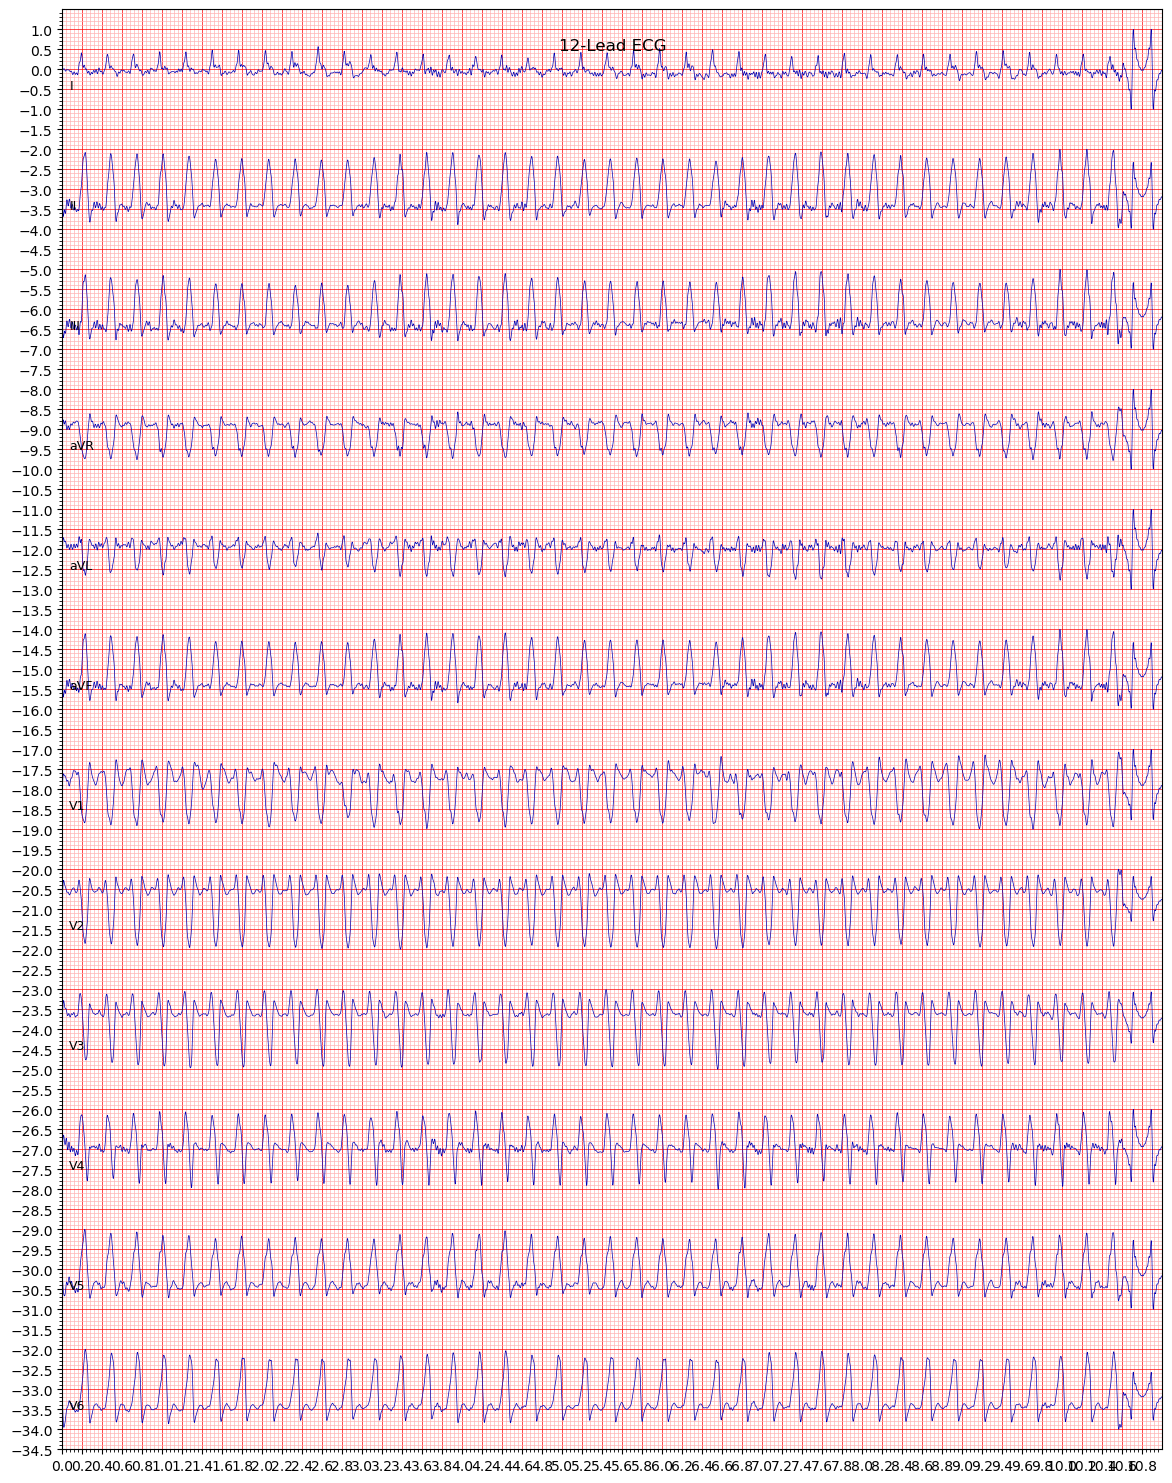

In [95]:
import ecg_plot
ecg_plot.plot(waveforms[19912], sample_rate=500, title='12-Lead ECG', columns=1)
ecg_plot.show()

## Confirm 12-lead ECGs we have are similar to training ECGs

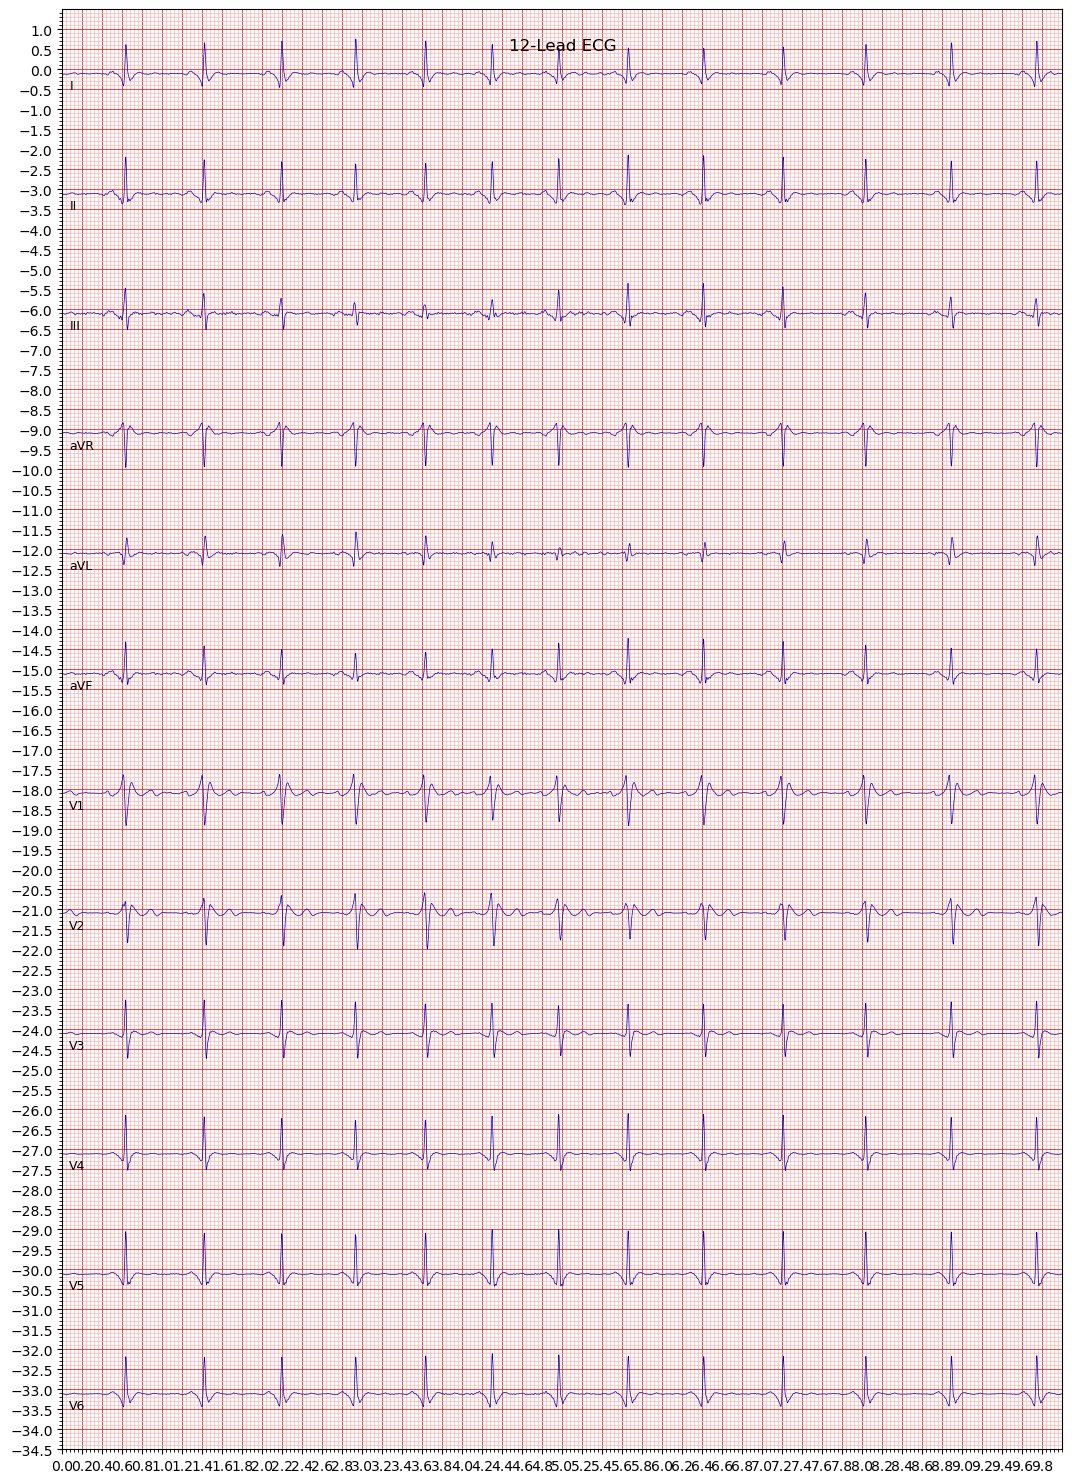

In [32]:
import ecg_plot

data = waveforms[19910]
data = data[:, :5000]
data = apply_filter(data, [3, 45])
data = normalize(data)

ecg_plot.plot(data, sample_rate=500, title='12-Lead ECG', columns=1)
ecg_plot.show()

In [6]:
from scipy.io import loadmat
from scipy.signal import decimate, resample

def load_challenge_data(header_file, fs=500, lead=2, random_lead_5=False, average_lead_5=False, random_lead_all=False, average_lead_all=False, window_length=7500):
    with open(header_file, 'r') as f:
        header = f.readlines()    
    sampling_rate = int(header[0].split()[2])    
    mat_file = header_file.replace('.hea', '.mat')
    try:
        x = loadmat(mat_file)
        recording = np.asarray(x['val'], dtype=np.float64)
        # print(f"LOAD MAT = {recording.shape}")
    except Exception as error:
        print(error)
        print(f"Found mat_file that couldn't be loaded: {mat_file}")
        recording = np.zeros((12, window_length))
    
    # Standardize sampling rate
    if sampling_rate > fs:
        recording = decimate(recording, int(sampling_rate / fs))
    elif sampling_rate < fs:
        recording = resample(recording, int(len(recording) * (fs / sampling_rate)))
    
    # print(f"LOAD MAT 2 = {recording.shape}")
    return recording, header


In [23]:
data, header = load_challenge_data("/deep/group/aihc-bootcamp-fall2020/selfecg/archive/raw/Q2345.hea")
data.shape

(12, 5000)

In [24]:

from biosppy.signals import ecg
from biosppy.signals.tools import filter_signal

def apply_filter(signal, filter_bandwidth, fs=500):
        # Calculate filter order
        order = int(0.3 * fs)
        # Filter signal
        signal, _, _ = filter_signal(signal=signal, ftype='FIR', band='bandpass',
                                     order=order, frequency=filter_bandwidth, 
                                     sampling_rate=fs)
        return signal
        
def normalize(seq, smooth=1e-8):
    ''' Normalize each sequence between -1 and 1 '''
    return 2 * (seq - np.min(seq)) / (np.max(seq) - np.min(seq) + smooth) - 1


In [25]:

# Apply band pass filter
data = apply_filter(data, [3, 45])
data = normalize(data)

# Add just enough padding to allow window
seq_len = data.shape[-1] # get the length of the ecg sequence
print(seq_len)
pad = abs(min(seq_len - 5000, 0))
print(pad)
if pad > 0:
    data = np.pad(data, ((0,0),(0,pad+1)))
    seq_len = data.shape[-1] # get the new length of the ecg sequence

print(seq_len)
starts = np.random.randint(seq_len - 5000 + 1, size=1) # get start indices of ecg segment     
print(starts)
if len(data) > 12:
    print(f"File {filename} had unexpected shape {data.shape}")
    data = data[:12, :]

ecg_segs = np.array([data[:,start:start+5000] for start in starts])


5000
0
5000
[0]


In [26]:
ecg_segs.shape

(1, 12, 5000)

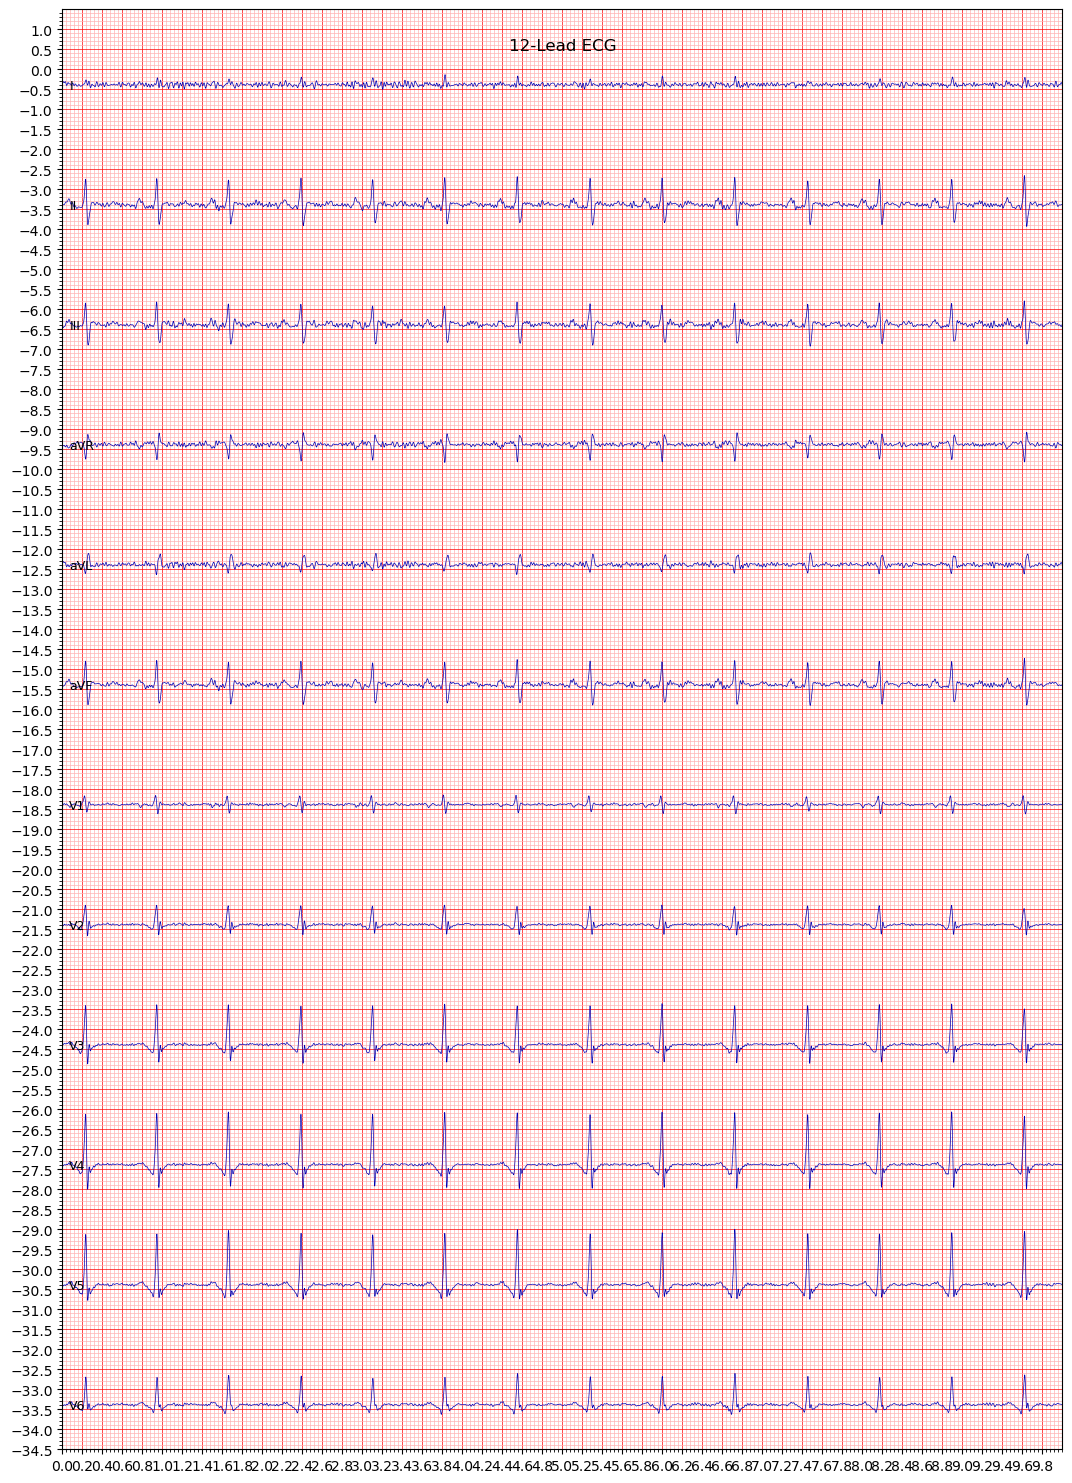

In [27]:
import ecg_plot
ecg_plot.plot(ecg_segs[0], sample_rate=500, title='12-Lead ECG', columns=1)
ecg_plot.show()

## ECG Summary vs Extracted Waveforms

In [14]:
print(f"CSNs in the summary file: {len(ecgs['PAT_ENC_CSN_ID'].tolist())}")
print(f"Unique CSNs: {len(set(ecgs['PAT_ENC_CSN_ID'].tolist()))}")

CSNs in the summary file: 40702
Unique CSNs: 22001


In [15]:
ecgs_csns = set(ecgs["PAT_ENC_CSN_ID"].tolist())

### Why are there more CSNs in the extracted waveforms?

In [16]:
csn_to_count = {}
for i, row in ecgs.iterrows():
    csn = row["PAT_ENC_CSN_ID"]
    if csn not in csn_to_count:
        csn_to_count[csn] = 0
    csn_to_count[csn] += 1
print(len(csn_to_count))

22001


In [ ]:
# Why are there more CSNs in the processed file?
i = 0
for csn in valid_csns:
    if int(csn) not in csn_to_count:
        print(f"{csn} in processed CSN file but not in ECG summary file")
    else:
        if valid_csns[csn] != csn_to_count[csn]:
            print(f"{csn} has count {valid_csns[csn]} in processed CSN file but {csn_to_count[csn]} in ECG summary file")
    i += 1
    if i > 10:
        break
print("...")

**Conclusion:** Some patients have more recorded waveforms than what was provided in the summary. Some patients also have an unusually alrge number of ECGs done.

### How many myocardial injury patients are in the extracted waveforms?

In [23]:
outcome_0 = 0
outcome_1 = 0
for csn in consolidated_csns:
    if csn not in valid_csns:
        outcome = consolidated[consolidated["CSN"] == csn].iloc[0]["outcome"]
        if outcome == 0:
            outcome_0 += 1
        else:
            outcome_1 += 1
print("---")
print(f"Missing Outcome 0 = {outcome_0} {100* (outcome_0) / len(consolidated[consolidated['outcome'] == 0])}%")
print(f"Missing Outcome 1 = {outcome_1} {100* (outcome_1) / len(consolidated[consolidated['outcome'] == 1])}%")
print(f"Missing Total     = {outcome_0 + outcome_1} {100* (outcome_0 + outcome_1) / len(consolidated)}%")

---
Missing Outcome 0 = 569 5.796068045227666%
Missing Outcome 1 = 55 5.203405865657522%
Missing Total     = 624 5.738458708846791%


## Waveform Plot

In [ ]:
consolidated.head(3)

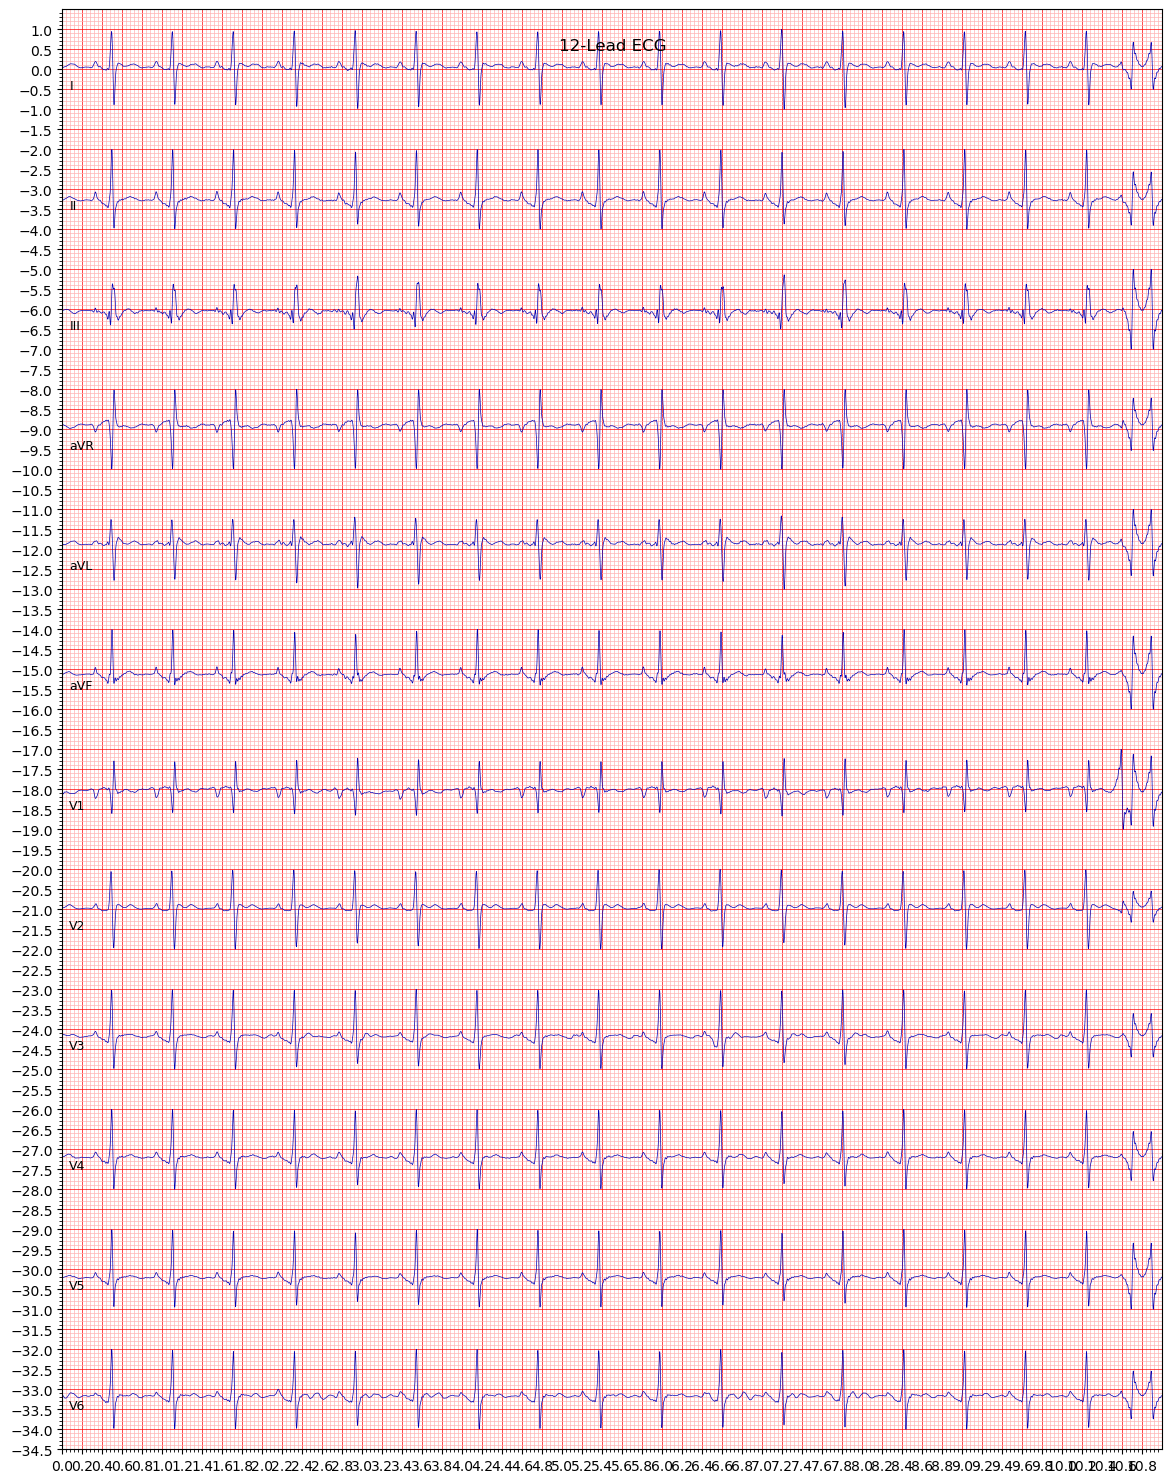

In [26]:
import ecg_plot
ecg_plot.plot(waveforms[0], sample_rate=500, title='12-Lead ECG', columns=1)
ecg_plot.show()

## Training

We train a Transformer model using 10 sec PhysioNet 12-lead ECG data, in the same way we trained single lead data.

```
python -u /deep/u/tomjin/aihc-aut20-selfecg/prna/train_model_wide_12lead.py /deep/group/aihc-bootcamp-fall2020/selfecg/archive/raw outputs-wide-64-12lead 64 5000 64
```

We also apply our pre-trained model to our waveforms to produce embeddings for our 12-lead.

```
python -u /deep/u/tomjin/ed-monitor-data/processing/apply_pretrained_transformer_12leads.py -i /deep/group/ed-monitor/admission-ecgs/v1/processed.dat.npy -s /deep/group/ed-monitor/admission-ecgs/v1/processed.csv -o /deep/group/ed-monitor/patient_data_v9/waveforms/12-lead -m /deep/u/tomjin/aihc-aut20-selfecg/prna/outputs-wide-64-12lead/saved_models/ctn/fold_1/ctn.tar -c /deep/group/ed-monitor/patient_data_v9/consolidated.filtered.csv
```